# Regularization

-> help with the overfitting problem

In [4]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from reg_utils import *
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

* blue -> French player managed to hit the ball with his/her head
* red -> other team's player hit the ball with their head

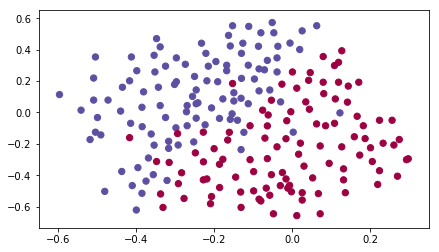

In [5]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Analysis of the dataset:
* a bit noise, some overlapping area and some "outliers"
* looks like the diagonal line is seperating two class

## 1- Non-regularized model

In [24]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, 
         print_cost = True, lambd = 0, keep_prob = 1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1] # 3 layer
    
    # Initilize
    parameters = initialize_parameters(layers_dims)
    
    # Loop
    for i in range(0, num_iterations):
        
        # Forward prop: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
            
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        # Backward prop
        assert(lambd == 0 or keep_prob == 1)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
            
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {} : {}".format(i, cost))
            
        if print_cost and i % 1000 == 0:
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1, 000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0 : 0.6557412523481002
Cost after iteration 10000 : 0.16329987525724213
Cost after iteration 20000 : 0.13851642423253263


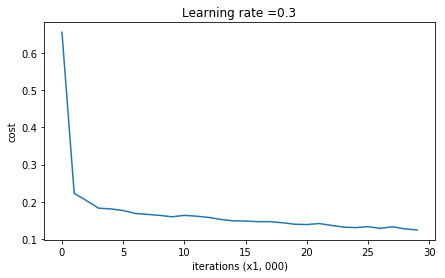

On the training set:
Accuracy: 0.947867298578
On the test set:
Accuracy: 0.915


In [7]:
parameters = model(train_X, train_Y)
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)


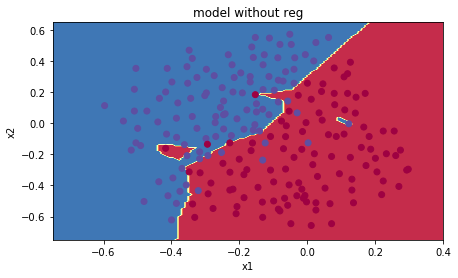

In [8]:
plt.title("model without reg")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 2 - L2 Regularization


The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [9]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) 
    L2_regularization_cost = lambd * (np.sum(np.square(W1))) + np.sum(np.square(W2)) + (np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [10]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 9.55997035181


Backward prop for L2 regularization

**Exercise**: Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [11]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1. / m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    db3 = 1. / m * np.sum(dZ3, axis = 1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    dW2 = 1. / m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1. / m* np.dot(dZ1, X.T) + (lambd * W1) / m
    
    db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
    
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [12]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print("dW1 = " + str(grads["dW1"]))
print("dW2 = " + str(grads["dW2"]))
print("dW3 = " + str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


run it with l2

Cost after iteration 0 : 18.78336125336132
Cost after iteration 10000 : 15.145854343603398
Cost after iteration 20000 : 16.35933255087118


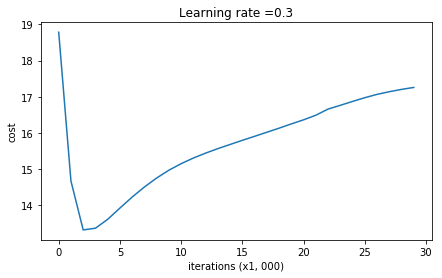

On the train set:
Accuracy: 0.938388625592
On the test set:
Accuracy: 0.93


In [13]:
parameters = model(train_X, train_Y, lambd=0.7)
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

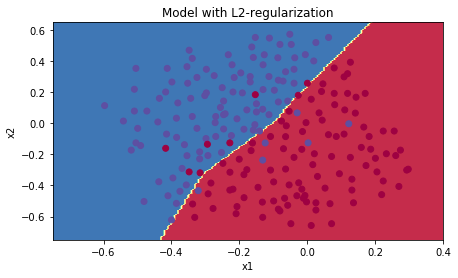

In [14]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

L2 Regularization actually doing

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

<font color='blue'>
**What you should remember** -- the implications of L2-regularization on:
- The cost computation:
    - A regularization term is added to the cost
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices
- Weights end up smaller ("weight decay"): 
    - Weights are pushed to smaller values.

## 3 - Dropout

Drop out 
        -> another regularization technique specific to deep learning. 
        
        -> Randomly shuts down some neurons in each iteration
        
So you actually train your model using only a subset of your neurons. With drop out, your neurons become less sensitive to the activation of one specific neuron

#### 3.1 -- Forward propagation with dropout


**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. In lecture, we dicussed creating a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 1 with probability (`keep_prob`), and 0 otherwise.

**Hint:** Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.
This python statement:  
`X = (X < keep_prob).astype(int)`  

is conceptually the same as this if-else statement (for the simple case of a one-dimensional array) :

```
for i,v in enumerate(x):
    if v < keep_prob:
        x[i] = 1
    else: # v >= keep_prob
        x[i] = 0
```
Note that the `X = (X < keep_prob).astype(int)` works with multi-dimensional arrays, and the resulting output preserves the dimensions of the input array.

Also note that without using `.astype(int)`, the result is an array of booleans `True` and `False`, which Python automatically converts to 1 and 0 if we multiply it with numbers.  (However, it's better practice to convert data into the data type that we intend, so try using `.astype(int)`.)

3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [17]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1    # regular linear
    A1 = relu(Z1)             # activate by relu

    D1 = np.random.rand(A1.shape[0], A1.shape[1])    
    D1 = D1 < keep_prob     # convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1             # update A1
    A1 = A1 / keep_prob       # scale the neurons left
    
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    # basically hardcode the same thing for layer 2
    D2 = np.random.rand(A2.shape[0], A2.shape[1])   
    D2 = D2 < keep_prob                                               
    A2 = A2 * D2                        
    A2 = A2 / keep_prob                 
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

Backward prop with dropout

In [19]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2      # still apply it to the neurons dropped out
    dA2 = dA2 / keep_prob # scale the neurons eft

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    # repeat the previous process
    dA1 = dA1 * D1      
    dA1 = dA1 / keep_prob    
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [20]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob=0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0 : 0.6543912405149825


/home/jovyan/work/week5/Regularization/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/jovyan/work/week5/Regularization/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000 : 0.06101698657490562
Cost after iteration 20000 : 0.060582435798513114


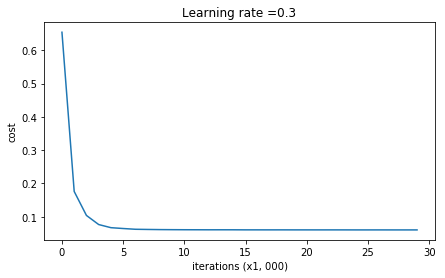

On the train set:
Accuracy: 0.928909952607
On the test set:
Accuracy: 0.95


In [25]:
# see the result
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3)

print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

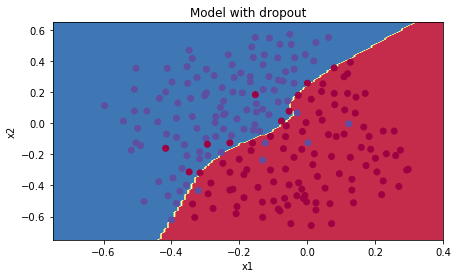

In [26]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**NOTE**:
* a common mistake using dropout is use it for both training and testing. you should only use it for training
* Dropout is a regularization technique
* Apply it on both forward and backward prop
* during training, divide each dropout layer by keep_prob to keep the same expected value for activations i.e. scale the neurons left

### 4 - Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>

    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

the take-homes:
* REgularization help you reduce overfitting, it may hurts training set performance cuz it limits the ability of overfitting
* REgularization drive your weights to lower values
* L2 REgularization and Dropout are two effective regularization techniques